In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

from sklearn.decomposition import PCA

from typing import Any
from typing import Dict
from typing import List
from typing import Optional
from typing import Tuple

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


import os
import math

from sklearn.model_selection import train_test_split

from support_classes import *

In [2]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

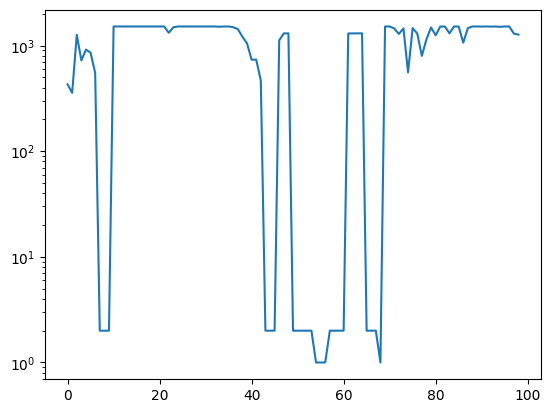

In [3]:
df = pd.read_excel('data_for_mle_test.xlsx')

number_of_unique_possibilities = []

for i in range(99):
    number_of_unique_possibilities.append(len(np.unique(df[i] )))
plt.plot(number_of_unique_possibilities)
plt.yscale('log')

df = df.drop(columns = np.where(np.asarray(number_of_unique_possibilities)==1)[0])

n = len(df)
df_train = df[0:int(n*0.7)]

df_val = df[int(n*0.7):int(n*0.8)]
df_test = df[int(n*0.8):]

num_features = df.shape[1]

df_train_categorical = df_train[np.where(np.asarray(number_of_unique_possibilities)==2)[0]]
df_train_continuous = df_train[np.where(np.asarray(number_of_unique_possibilities)>10)[0]]

df_test_categorical = df_test[np.where(np.asarray(number_of_unique_possibilities)==2)[0]]
df_test_continuous = df_test[np.where(np.asarray(number_of_unique_possibilities)>10)[0]]

df_val_categorical = df_val[np.where(np.asarray(number_of_unique_possibilities)==2)[0]]
df_val_continuous = df_val[np.where(np.asarray(number_of_unique_possibilities)>10)[0]]

In [4]:
train_mean = df_train_continuous.mean()
train_std = df_train_continuous.std()

df_train_continuous = (df_train_continuous - train_mean) / train_std
df_val_continuous = (df_val_continuous - train_mean) / train_std
df_test_continuous = (df_test_continuous - train_mean) / train_std

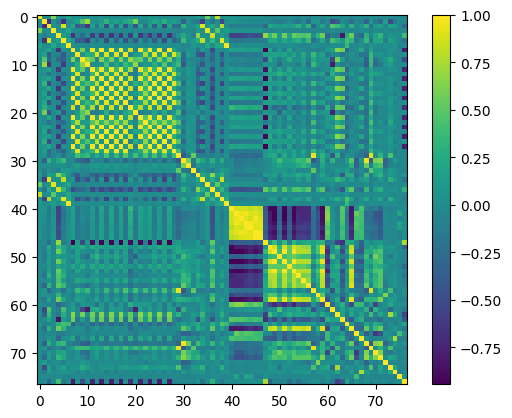

In [5]:
plt.imshow(np.cov(np.asarray(df_train_continuous).T))
plt.colorbar()

In [6]:
eigenvalues, eigenvectors = np.linalg.eig(np.cov(df_train_continuous.T))

scaled_data_shuffled = np.asarray(df_train_continuous).copy()

eigenvalues_shuffled = np.zeros((100, df_train_continuous.shape[1]))

import random

for r in range(100):
    for col in range(scaled_data_shuffled.shape[1]):
        scaled_data_shuffled[:,col] = scaled_data_shuffled[random.sample(range(scaled_data_shuffled.shape[0]), scaled_data_shuffled.shape[0]), 
                                                           col]
    eigenvalues_shuffled[r] = np.linalg.eig(
        np.cov(scaled_data_shuffled.T))[0]

In [7]:
pca_data = PCA(n_components=np.where(np.greater(np.mean(eigenvalues_shuffled, axis=0), eigenvalues))[0][0])

pca_data.fit(np.asarray(df_train_continuous))

pcaed_df_train_continuous = pca_data.transform(np.asarray(df_train_continuous))

pcaed_df_val_continuous = pca_data.transform(np.asarray(df_val_continuous))

pcaed_df_test_continuous = pca_data.transform(np.asarray(df_test_continuous))

In [8]:
pcaed_df_train = np.concatenate((pcaed_df_train_continuous, df_train_categorical), axis=1)

pcaed_df_val = np.concatenate((pcaed_df_val_continuous, df_val_categorical), axis=1)

pcaed_df_test = np.concatenate((pcaed_df_test_continuous, df_test_categorical), axis=1)

In [9]:
pcaed_df_train = pd.DataFrame(pcaed_df_train)
pcaed_df_test = pd.DataFrame(pcaed_df_test)
pcaed_df_val = pd.DataFrame(pcaed_df_val)

pcaed_df_train['target']=df_train[4].values
pcaed_df_test['target']=df_test[4].values
pcaed_df_val['target']=df_val[4].values

In [10]:
train_mean = pcaed_df_train.mean()
train_std = pcaed_df_train.std()

train_df = (pcaed_df_train - train_mean) / train_std
val_df = (pcaed_df_val - train_mean) / train_std
test_df = (pcaed_df_test - train_mean) / train_std

In [13]:
wide_window = WindowGenerator(
                input_width=2, label_width=2, shift=1,
                label_columns=['target'], train_df=train_df, val_df=val_df, test_df=test_df)
lstm_model = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(4096, return_sequences=True),
                tf.keras.layers.LSTM(4096, return_sequences=True),
                # Shape => [batch, time, features]
                tf.keras.layers.Dense(units=1)
            ])

history = compile_and_fit(lstm_model, wide_window)



Metal device set to: Apple M2
Epoch 1/100


2023-04-03 21:46:40.809614: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


34/34 [==============================] - 76s 366ms/step - loss: 0.3346 - mean_absolute_error: 0.3938 - val_loss: 0.5394 - val_mean_absolute_error: 0.4858
Epoch 2/100
34/34 [==============================] - 12s 357ms/step - loss: 0.1252 - mean_absolute_error: 0.2352 - val_loss: 1.4051 - val_mean_absolute_error: 0.7016
Epoch 3/100
34/34 [==============================] - 12s 344ms/step - loss: 0.0915 - mean_absolute_error: 0.1959 - val_loss: 0.5628 - val_mean_absolute_error: 0.4621
Epoch 4/100
34/34 [==============================] - 12s 343ms/step - loss: 0.0780 - mean_absolute_error: 0.1764 - val_loss: 0.9773 - val_mean_absolute_error: 0.6037
Epoch 5/100
34/34 [==============================] - 12s 343ms/step - loss: 0.1622 - mean_absolute_error: 0.2539 - val_loss: 1.6215 - val_mean_absolute_error: 0.6646
Epoch 6/100
34/34 [==============================] - 12s 344ms/step - loss: 0.1433 - mean_absolute_error: 0.2558 - val_loss: 0.8176 - val_mean_absolute_error: 0.5581
Epoch 7/100
34/3

AttributeError: 'Sequential' object has no attribute 'save_model'

In [14]:
lstm_model.save('trailstone_assessment_model')

INFO:tensorflow:Assets written to: trailstone_assessment_model/assets


INFO:tensorflow:Assets written to: trailstone_assessment_model/assets


In [38]:
loaded_model = tf.keras.models.load_model('trailstone_assessment_model/')

In [39]:
test_prediction = loaded_model.predict(wide_window.make_dataset(test_df, False, test_df.shape[0]))
train_prediction = loaded_model.predict(wide_window.make_dataset(train_df, False, train_df.shape[0]))
val_prediction = loaded_model.predict(wide_window.make_dataset(val_df, False, val_df.shape[0]))

1/1 [==============================] - 0s 202ms/step


In [41]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 4096)           67649536  
                                                                 
 lstm_1 (LSTM)               (None, 2, 4096)           134234112 
                                                                 
 dense (Dense)               (None, 2, 1)              4097      
                                                                 
Total params: 201,887,745
Trainable params: 201,887,745
Non-trainable params: 0
_________________________________________________________________


In [43]:
def collate_predictions(predictions, df):

    predictions_collated = np.zeros(df.shape[0])
    j=0
    for i in range(df.shape[0]):

        if i<predictions.shape[0]:
            predictions_collated[i] = predictions[i,0,0]
        else:

            predictions_collated[i] = predictions[-1, j,0]
            j+=1
    return predictions_collated

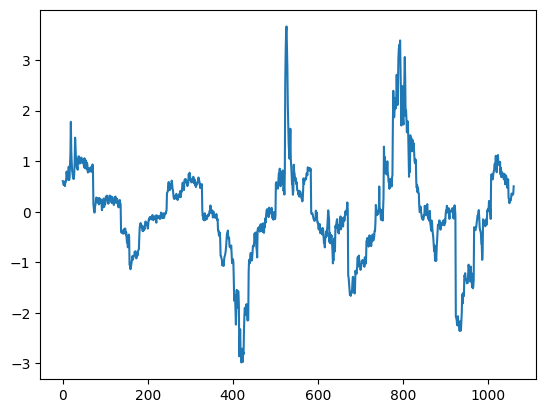

In [44]:
plt.plot(train_predictions_collated)

In [33]:
train_predictions_collated = collate_predictions(train_prediction, df_train)
test_predictions_collated = collate_predictions(test_prediction, df_test)
val_predictions_collated = collate_predictions(val_prediction, df_val)


In [35]:
holdings = (np.asarray(np.diff(train_predictions_collated)>0, dtype=float)-1/2)*2
sum(holdings * df_train[0][1:])/sum(abs(df_train[0][1:]))

0.7519363166953535

In [36]:
holdings = (np.asarray(np.diff(val_predictions_collated)>0, dtype=float)-1/2)*2
sum(holdings * df_val[0][1:])/sum(abs(df_val[0][1:]))

0.6687285223367693

In [37]:
holdings = (np.asarray(np.diff(test_predictions_collated)>0, dtype=float)-1/2)*2
sum(holdings * df_test[0][1:])/sum(abs(df_test[0][1:]))

0.6635154061624645

In [ ]:
test_df = pd.read_excel('your_file_here') ##input your filename here

df_test_categorical = test_df[np.where(np.asarray(number_of_unique_possibilities)==2)[0]]
df_test_continuous = test_df[np.where(np.asarray(number_of_unique_possibilities)>10)[0]]

df_test_continuous = (df_test_continuous - train_mean) / train_std

pcaed_df_test_continuous = pca_data.transform(np.asarray(df_test_continuous))

pcaed_df_test = np.concatenate((pcaed_df_test_continuous, df_test_categorical), axis=1)

pcaed_df_test['target']=test_df[4].values



loaded_model = tf.keras.models.load_model('trailstone_assessment_model/')

wide_window = WindowGenerator(
                input_width=2, label_width=2, shift=1,
                label_columns=['target'], train_df=None, val_df=None, test_df=test_df)



In [ ]:
test_prediction = loaded_model.predict(wide_window.make_dataset(test_df, False, test_df.shape[0]))
test_predictions_collated = collate_predictions(test_prediction, test_df)

In [ ]:
holdings = (np.asarray(np.diff(test_predictions_collated)>0, dtype=float)-1/2)*2
sum(holdings * df_test[0][1:])/sum(abs(df_test[0][1:]))